# D213 - Advanced Data Analytics
## NLM3 TASK 1 - TIME SERIES MODELING
### Western Governor's University - October 27, 2024
*Performed by Kevin Rupe, 011165981, krupe6@wgu.edu, (864) 704-2340*

# Table of Contents
* [PART I: RESEARCH QUESTION](#part1)
    * [A1: RESEARCH QUESTION](#a1)
    * [A2: OBJECTIVE OR GOALS](#a2)
* [PART II: METHOD JUSTIFICATION](#part2)
    * [B: SUMMARY OF ASSUMPTIONS](#b)
* [PART III: DATA PREPARATION](#part3)
    * [C1: LINE GRAPH OF VISUALIZATION](#c1)
    * [C2: TIME STEP FORMATTING](#c2)
    * [C3: STATIONARITY](#c3)
    * [C4: STEPS TO PREPARE THE DATA](#c4)
    * [C5: PREPARED DATA SET](#c5)
* [PART IV: MODEL IDENTIFICATION AND ANALYSIS](#part4)
    * [D1: REPORT FINDINGS AND VISUALIZATIONS](#d1)
        * [SEASONALITY](#d1.1)
        * [TRENDS](#d1.2)
        * [AUTOCORRELATION FUNCTION](#d1.3)
        * [SPECTRAL DENSITY](#d1.4)
        * [DECOMPOSED TIME SERIES](#d1.5)
        * [RESIDUALS OF THE DECOMPOSED TIME SERIES](#d1.6)
    * [D2: ARIMA MODEL](#d2)
    * [D3: FORECASTING USING ARIMA MODEL](#d3)
    * [D4: OUTPUT AND CALCULATIONS](#d4)
    * [D5: CODE](#d5)
* [PART V: DATA SUMMARY AND IMPLICATIONS](#part5)
    * [E1: RESULTS](#e1)
        * [THE SELECTION OF THE ARIMA MODEL](#e1.1)
        * [THE PREDICTION INTERVAL OF THE FORECAST](#e1.2)
        * [A JUSTIFICATION OF THE FORECAST LENGTH](#e1.3)
        * [THE MODEL EVALUATION PROCEDURE AND ERROR METRIC](#e1.4)
    * [E2: ANNOTATED VISUALIZATION](#e2)
    * [E3: RECOMMENDATION](#e3)
* [PART VI: REPORTING](#part6)
    * [F: REPORTING](#f)
    * [G: SOURCES FOR THIRD-PARTY CODE](#g)
    * [H: SOURCES](#h)

## PART I: RESEARCH QUESTION <a class="anchor" id="part1"></a>

### A1: RESEARCH QUESTION <a class="anchor" id="a1"></a>

Is it possible to predict a useful 90-day hospital revenue forecast with ARIMA model?

### A2: OBJECTIVES OR GOALS <a class="anchor" id="a2"></a>

The main objective of this analysis is to determine if hospital revenue can be predicted with an ARIMA model so that organizational leadership can create a strategy to increase future revenue. A goal of mine is to be able to use both training and testing sets to test the effectiveness of future predictions. 

## PART II: METHOD JUSTIFICATION <a class="anchor" id="part2"></a>

### B: SUMMARY OF ASSUMPTIONS <a class="anchor" id="b"></a>

The primary assumption in a time series analysis is that the data is stationary. This means that there are no underlying patterns in the data (i.e., the data is stable) (Statistics Solutions, 2024). It is also assumed that there are no outliers. Outliers can distort the analysis much the same way stationarity can. The residuals are also assumed to be independent and normally distributed. The last assumption is about external unknown disturbances impacting the data. We assume they are random with a mean of zero and constant variance.


## PART III: DATA PREPARATION <a class="anchor" id="part3"></a>

In [96]:
#import libraries

import pandas as pd
import numpy as np
from numpy import cumsum
import os #view operating system information
import joblib #to save and load model

from scipy import signal #for periodogram
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #for Dicky-Fuller Test function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX #Seasonal ARIMA analysis
statsmodels.tsa.arima.model.ARIMAResults.get_forecast

import pmdarima as pm
from pmdarima.arima import auto_arima

import warnings #to ignore warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

In [81]:
from platform import python_version
print('Python version used for this analysis is:', python_version())

Python version used for this analysis is: 3.11.4


In [199]:
#import csv
df = pd.read_csv('C:/Users/e0145653/Documents/WGU/D213 - Advanced Data Analytics/PRFA - NLM3/medical_time_series.csv', 
                 index_col='Day', parse_dates=True)

In [83]:
df.shape

(731, 1)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


### C1: LINE GRAPH OF VISUALIZATION <a class="anchor" id="c1"></a>

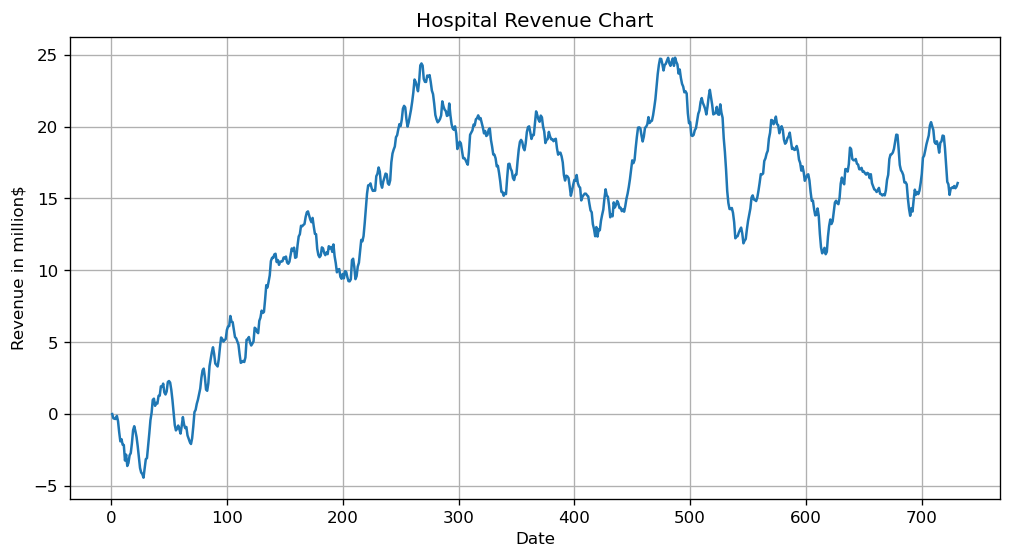

In [85]:
#visualize the time series on a graph
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Hospital Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue in million$')
plt.grid(True)
plt.show()

### C2: TIME STEP FORMATTING <a class="anchor" id="c2"></a>

There are 731 rows in this dataset. The first variable is a set of numbers from 1 to 731. The second variable is labeled as 'Revenue' in millions of USD. This appears to be indicating daily revenue for 2 years of data since 2 full years is 730 days. Given that we have 731 days, this implies there was a Leap Day. There are no gaps in measurement. There is nothing in the Data Dictionary that suggests what these dates are, so I'm going to use the beginning of the year, January 1, as a starting point. Given that I believe the data represents a Leap Year, I am going to start in the year 2020 which was the last full Leap Year. I will have to convert the index column to a date by using the `to_datetime` Pandas function.

### C3: STATIONARITY <a class="anchor" id="c3"></a>

Using the Dickey-Fuller test, we can test the stationarity of the time series dataset. This test was developed by David Dickey and Wayne Fuller in 1979 which “tests the null hypothesis that a unit root is present in an autoregressive (AR) time series model (‘Dickey-Fuller test’, n.d.).” If the time series indicates a stochastic trend, then we say that the time series is non-stationary and therefore makes it more difficult to draw statistical inferences from the data and to also predict futures. 

The results of the Dickey-Fuller test for the cleaned time series dataset are below:

In [89]:
#check for stationarity using Dickey-Fuller Test
class color:
   BOLD = '\033[1m'
   END = '\033[0m'
    
def adf_test(df):
    result = adfuller(df, autolag='AIC')
    print(color.BOLD + 'The results of the AD Fuller Test - using non-stationary data' + color.END)
    print('1. ADF: ', result[0])
    print('2. P-Value: ', result[1])
    print('3. Number of Lags: ', result[2])
    print('4. Number of Obs: ', result[3])
    print('5. Critical Values: ')
    for key, val in result[4].items():
        print('\t',key,': ',val)
    print('6. Best IC: ', result[5])

adf_test(df['Revenue'])

The results of the AD Fuller Test - using non-stationary data
1. ADF:  -2.2183190476089485
2. P-Value:  0.19966400615064228
3. Number of Lags:  1
4. Number of Obs:  729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163
6. Best IC:  842.453027617641


Using the p-value, we can determine if this value has statistical significance or not by measuring it against a predetermined alpha value of 0.05 which is a very common in statistical analysis.

In [90]:
result = adfuller(df['Revenue'], autolag='AIC')
alpha = 0.05

if result[1] >= alpha:
    print('The results are not statistically significant. Therefore, we cannot reject the null hypothesis, and must accept it.')
    print("")
    print("Test Statistic:", round(result[0],5))
    print("P-Value:", round(result[1],5))
else:
    print('The results are statistically significant. Therefore, we reject the null hypothesis.')
    print("")
    print("Test Statistic:", round(result[0],5))
    print("P-Value:", round(result[1],5))

The results are not statistically significant. Therefore, we cannot reject the null hypothesis, and must accept it.

Test Statistic: -2.21832
P-Value: 0.19966


### C4: STEPS TO PREPARE THE DATA <a class="anchor" id="c4"></a>

To start off, I wanted to rename the first column as *Date* instead of *Day*. Next, I assigned dates to the Date column by choosing the last calendar year where there was a Leap Day, which was the year 2020. I set the index to the Date column. 

In [200]:
# rename column as 'Date'
df = df.rename(columns={'Day': 'Date'})
# assign actual dates 
df['Date'] = (pd.date_range(start=datetime(2020, 1, 1),
            periods=df.shape[0], freq='24H'))
# set the index
df.set_index('Date', inplace=True)
# view the header
df.head()

,Revenue
Date,
2020-01-01,0.000000
2020-01-02,-0.292356
2020-01-03,-0.327772
2020-01-04,-0.339987
2020-01-05,-0.124888


Looking over the dataset, after assigning dates to the first column, I then looked for any missing or null (NaN) values using the `dropna` method. I found none, so this data appears to be for a full 2 years. 

In [201]:
print(df.isnull().values.any())
print(df.isna().values.any())
df = df.dropna()

False
False


Later on this in analysis, I want to use a training and testing dataset to evaluate how well the model can predict future revenue. So I need to split the data into training and testing sets. I wanted to split this into two different datasets where the testing set would be 90 days. So rather than using the `train_test_split` function, I split the original dataset manually based on dates, adjusting the testing dataset to the final 90 days (or 3 months) of data. 

In [202]:
#Create training and testing models
X_train = df.loc[:'2021-09-30']
X_test  = df.loc['2021-10-01':]

print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

X_train shape (639, 1)
X_test shape (92, 1)


### C5: PREPARED DATA SET <a class="anchor" id="c5"></a>

In [103]:
#export cleaned data
df.to_csv("C:/Users/e0145653/Documents/WGU/D213 - Advanced Data Analytics/PRFA - NLM3/NLM3 TASK 1 - TIME SERIES MODELING/medical_cleaned_D213_Task_1.csv",
    header = True, index = False)
#export training dataset
X_train.to_csv("C:/Users/e0145653/Documents/WGU/D213 - Advanced Data Analytics/PRFA - NLM3/NLM3 TASK 1 - TIME SERIES MODELING/medical_training_D213_Task_1.csv",
    header = True, index = False)
#export testing dataset
X_test.to_csv("C:/Users/e0145653/Documents/WGU/D213 - Advanced Data Analytics/PRFA - NLM3/NLM3 TASK 1 - TIME SERIES MODELING/medical_testing_D213_Task_1.csv",
    header = True, index = False)

A copy of the cleaned data sets has been provided in this Performance Assessment.

## PART IV: MODEL IDENTIFICATION AND ANALYSIS <a class="anchor" id="part4"></a>

### D1: REPORT FINDINGS AND VISUALIZATIONS <a class="anchor" id="d1"></a>

In [134]:
#show decomposition of the data
decomp = seasonal_decompose(df['Revenue'], period=90)

diff_decomp = seasonal_decompose(df_stationary['Return'], period=90)

#### SEASONALITY <a class="anchor" id="d1.1"></a>

The pattern in the below graph repeats every roughly 90 days. It spikes with the largest revenue in mid-February, mid-May, mid-August, and mid-November of each year, and then it drops drastically to the lowest revenue a few weeks later after each relevant spike. All of this shows a seasonality in our dataset that repeats every 90 days. This shows us that this dataset is not stationary. 

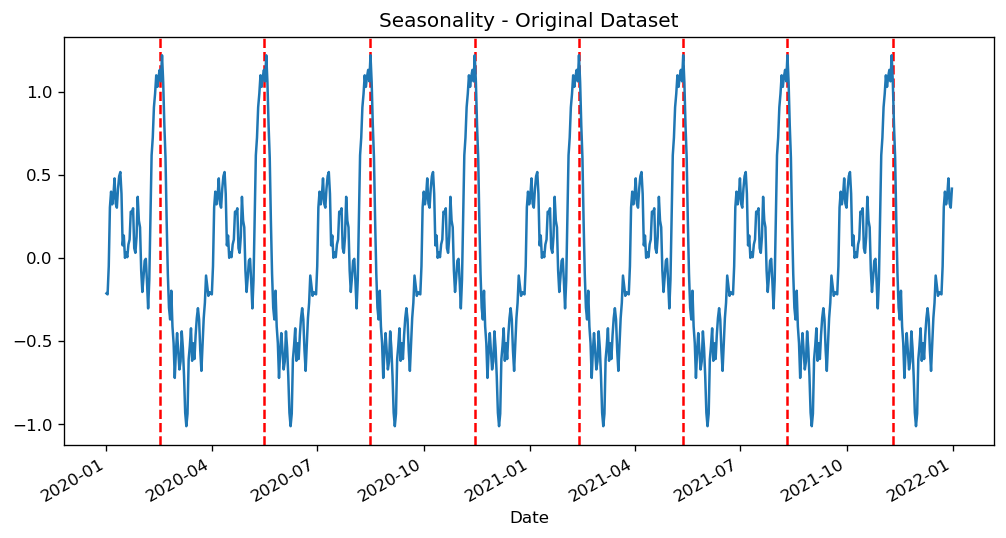

In [135]:
#plot the Seasonality graph

plt.figure(figsize=(10,5))
plt.axvline(x=pd.to_datetime('2020-02-16'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-05-16'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-08-16'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2020-11-14'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2021-02-12'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2021-05-13'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2021-08-11'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2021-11-10'), color='r', linestyle='--')
plt.title('Seasonality - Original Dataset')
decomp.seasonal.plot()
plt.show()

Differencing the dataset with an order of 1, we see less seasonality, more condensed, which suggests the seasonality is less significant. I figure we could take the 2nd difference in our dataset, but given the next graphs all show that the data is stationary, and the p-value of the differenced dataset is also statistically significant, then I will move on. 

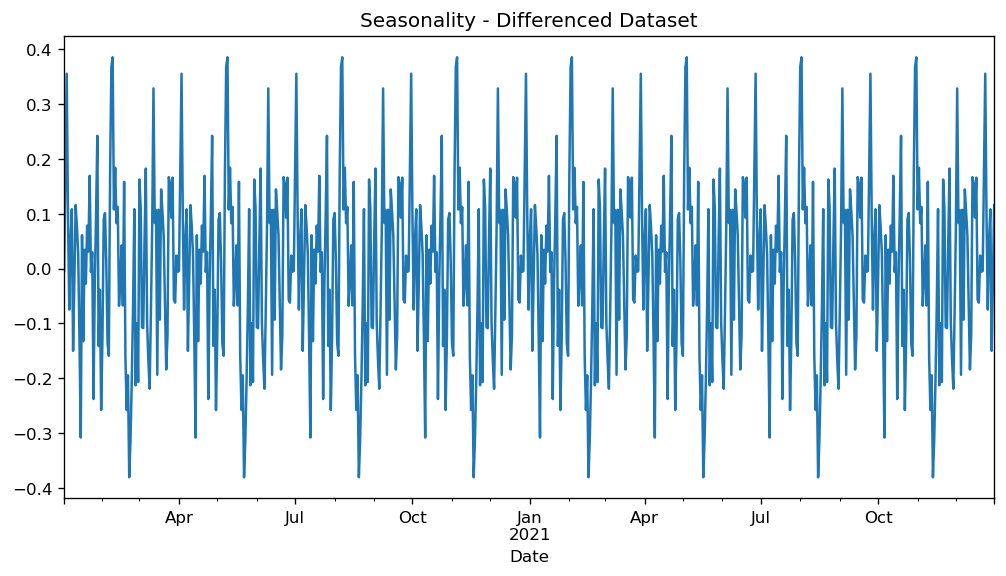

In [136]:
#plot the Seasonality graph

plt.figure(figsize=(10,5))
plt.title('Seasonality - Differenced Dataset')
diff_decomp.seasonal.plot()
plt.show()

#### TRENDS <a class="anchor" id="d1.2"></a>

This graph shows that revenue has a steep linear upward trend for the first 9 months until it begins to slope downward for about 6 months. It then again slopes upward around March for a few months until it trends downward again for 3 months. Around August 2021, in our dataset, the data looks to flatten out with no more steep inclines or declines. These trends further indicate that our dataset is not stationary. Comparing this to the differenced data, we see no trend whatsoever. 

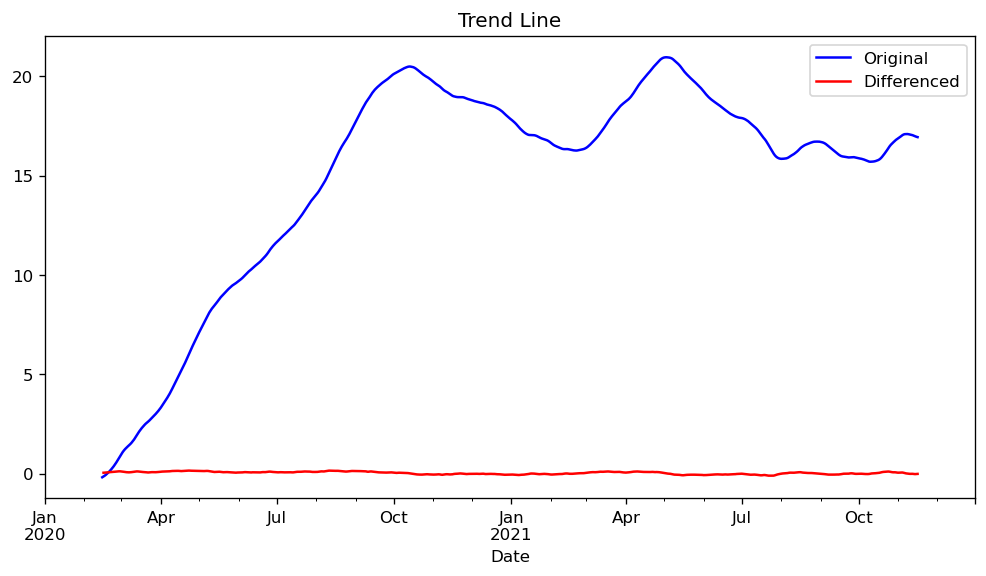

In [137]:
#plot the Trend graph

plt.figure(figsize=(10,5))
plt.title('Trend Line')
decomp.trend.plot(color='b', label='Original')
diff_decomp.trend.plot(color='r', label='Differenced')
plt.legend()
plt.show()

#### AUTOCORRELATION FUNCTION <a class="anchor" id="d1.3"></a>

The ACF (Autocorrelated Function) graph below shows a positive autocorrelation for 30 lags. Each lag extends beyond the confidence interval which indicates that there is a positive autocorrelation. This ACF graph shows the original time series data correlated to the lagged time series. But the differenced dataset shows only 2 lags outside of the confidence interval. This shows the stationarity of the differenced dataset.

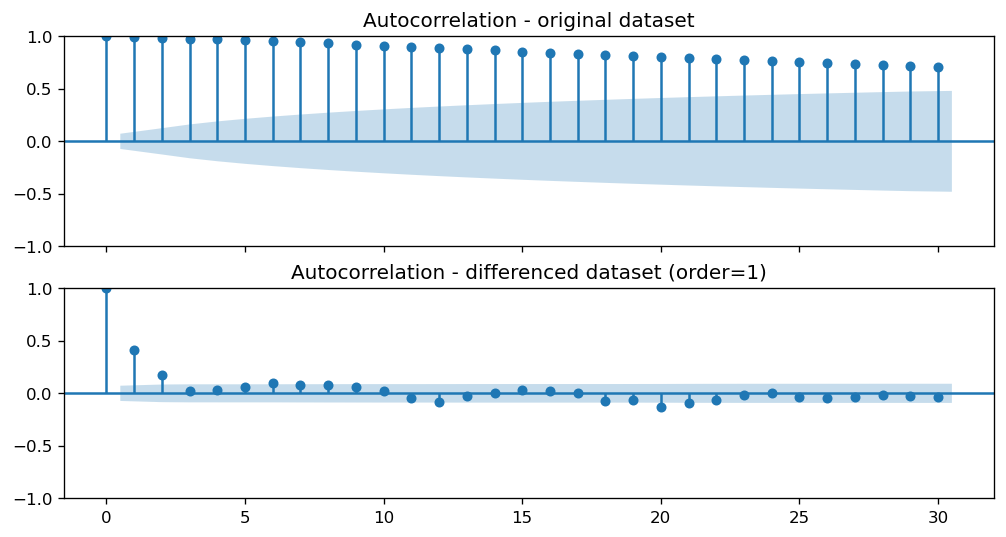

In [97]:
#Graph the ACF plot of the non-stationary data
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)
plot_acf(df.Revenue, ax=axs[0], lags=30, alpha=0.05)
axs[0].set_title('Autocorrelation - original dataset')
plot_acf(df_stationary.Return, ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('Autocorrelation - differenced dataset (order=1)')
#ax1 = fig.add_subplot(211)
#fig = plot_acf(df.Revenue, lags=30, ax=ax1)
#plt.title('Autocorrelation - non-stationary data')
plt.show()

The PACF (Partial Autocorrelation Function) shown below differs from the ACF as it removes the previous effects of each lag. This PACF displays a positive autocorrelation at the first lag, then a slightly negative autocorrelation at the second lag. The remaining lags show no autocorrelation. The differenced dataset removes the second negative autocorrelation, only showing a positive autocorrelation at lag 1. 

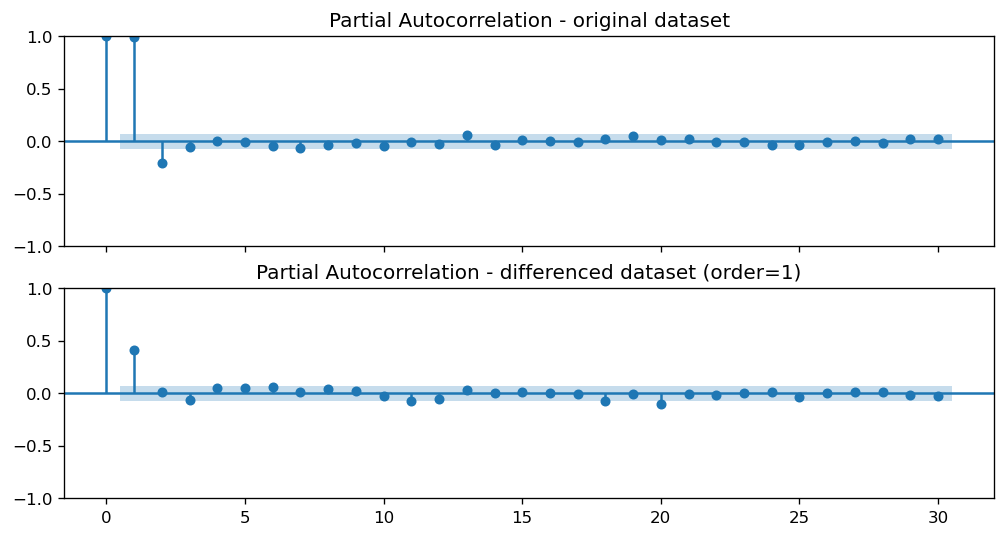

In [98]:
#Graph the ACF plot of the non-stationary data
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)
plot_pacf(df.Revenue, ax=axs[0], lags=30, alpha=0.05)
axs[0].set_title('Partial Autocorrelation - original dataset')
plot_pacf(df_stationary.Return, ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('Partial Autocorrelation - differenced dataset (order=1)')
#ax1 = fig.add_subplot(211)
#fig = plot_acf(df.Revenue, lags=30, ax=ax1)
#plt.title('Autocorrelation - non-stationary data')
plt.show()

A different viewpoint using Python's `autocorrelation_plot` function, this graph shows us how the original dataset is non-stationary, whereas the differenced dataset seems to be just slightly out of confidence interval and then shows no autocorrelation after that. Therefore, again the differenced dataset is stationary.

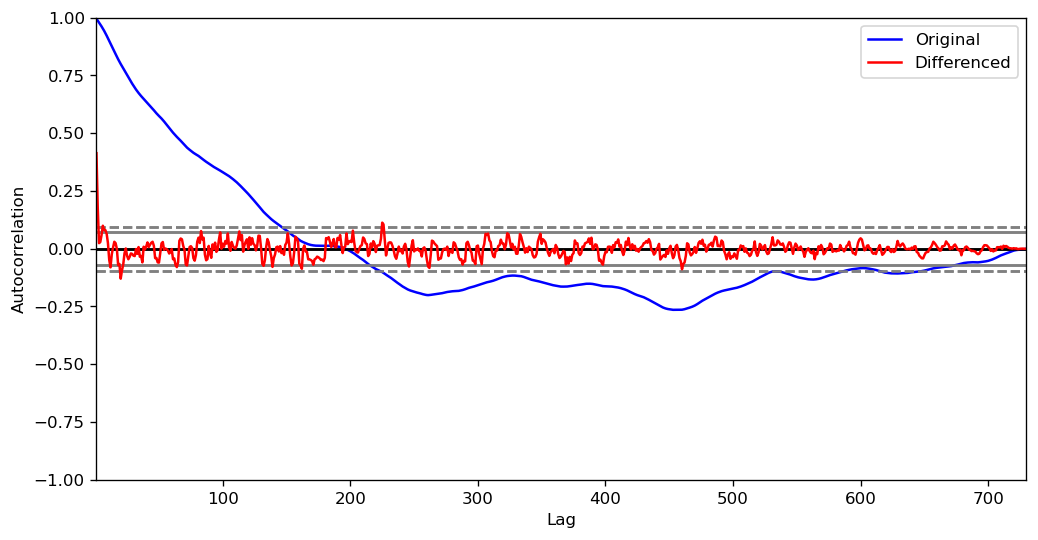

In [126]:
#Autocorrelation of non-stationary data
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi': 120})
autocorrelation_plot(df.Revenue.tolist(), color='b', label='Original')
autocorrelation_plot(df_stationary.Return.tolist(), color='r', label='Differenced')
plt.legend()
plt.show()

#### SPECTRAL DENSITY <a class="anchor" id="d1.4"></a>

The spectral density of the time series shows that the data has a downward trend, and thus is non-stationary. The graph does trend toward 10<sup>0</sup> (or 0) around the 0.2 frequency mark.

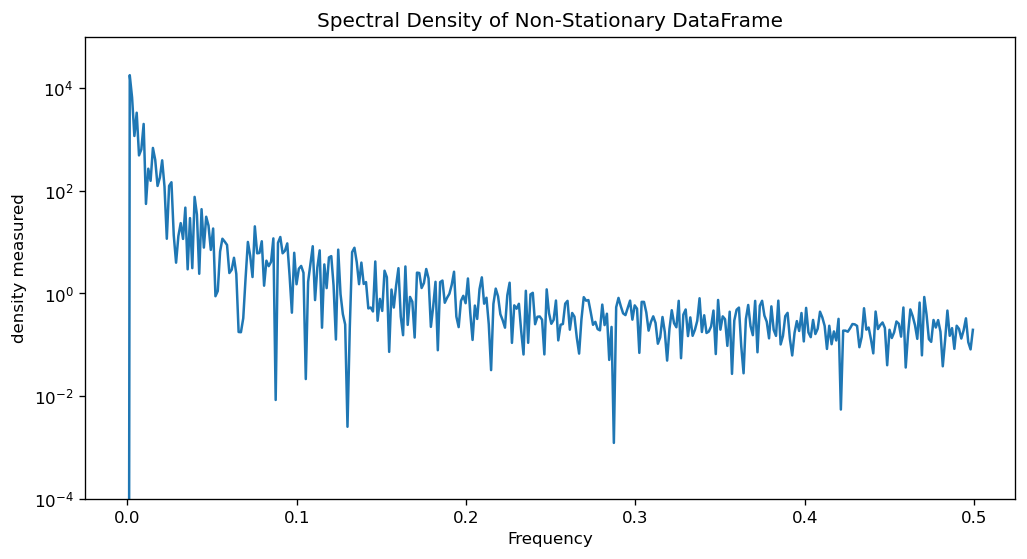

In [29]:
#Spectral Density Analysis - (Non-Stationary DataFrame) using periodogram

f, Pxx_den = signal.periodogram(df['Revenue'])
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-4, 1e5])
plt.title('Spectral Density of Non-Stationary DataFrame')
plt.xlabel('Frequency')
plt.ylabel('density measured')
plt.show()

The spectral density of the differenced time series shows that the data no longer has a downward trend, and thus is stationary. The graph stays around the 10<sup>0</sup> (or 0) mostly.

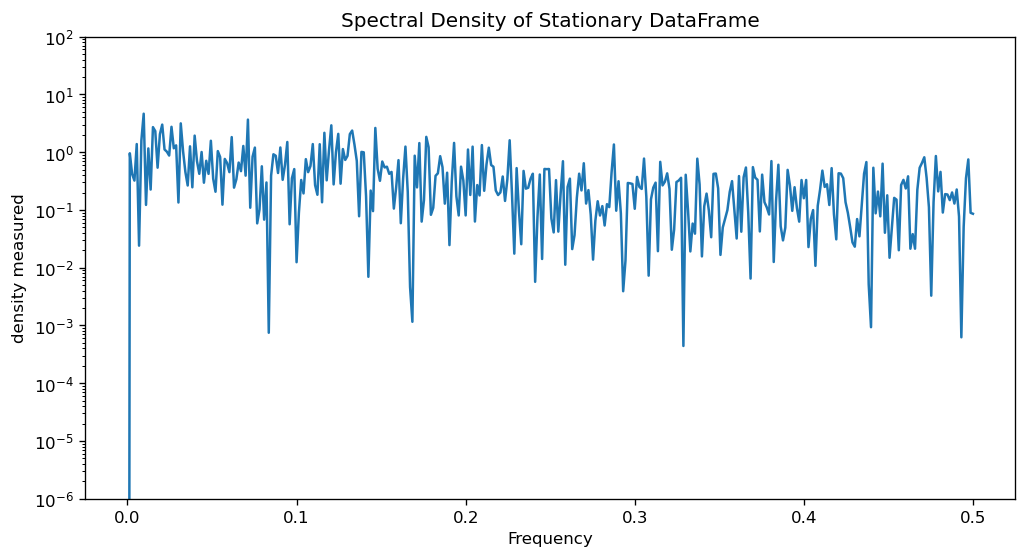

In [39]:
#Spectral Density of the stationary dataFrame using periodogram

f, Pxx_den = signal.periodogram(df_stationary['Return'])
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density of Stationary DataFrame')
plt.xlabel('Frequency')
plt.ylabel('density measured')
plt.show()

#### DECOMPOSED TIME SERIES <a class="anchor" id="d1.5"></a>

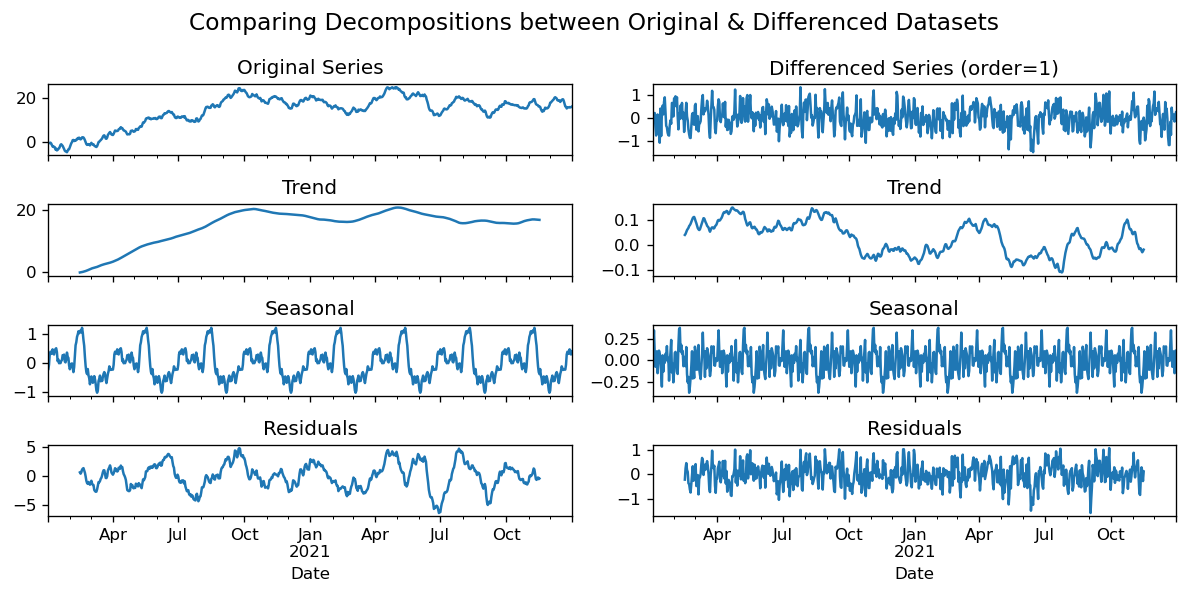

In [142]:
# plot the decompositions
fig, axs = plt.subplots(4,2, figsize=(10,5), sharex=True)
#original plots
decomp.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Original Series')
decomp.trend.plot(ax=axs[1,0])
axs[1,0].set_title('Trend')
decomp.seasonal.plot(ax=axs[2,0])
axs[2,0].set_title('Seasonal')
decomp.resid.plot(ax=axs[3,0])
axs[3,0].set_title('Residuals')
#difference plots
diff_decomp.observed.plot(ax=axs[0,1])
axs[0,1].set_title('Differenced Series (order=1)')
diff_decomp.trend.plot(ax=axs[1,1])
axs[1,1].set_title('Trend')
diff_decomp.seasonal.plot(ax=axs[2,1])
axs[2,1].set_title('Seasonal')
diff_decomp.resid.plot(ax=axs[3,1])
axs[3,1].set_title('Residuals')
fig.suptitle('Comparing Decompositions between Original & Differenced Datasets', fontsize=14)
fig.tight_layout()
plt.show()

#### RESIDUALS OF THE DECOMPOSED TIME SERIES <a class="anchor" id="d1.6"></a>

This graph shows any patterns in the dataset after removing the trend, seasonality, and other components. There are several things to notice in the chart below. The graph appears to be random (i.e., no discernible patterns). But we can see the differenced data is clearly more close to zero, and it appears visually that this graph centers on the zero line. The variance of this stationary data is homoscedastic showing no variance over time. For these reasons, this all confirms that the decomposition has successfully captured the underlying patterns in the data.

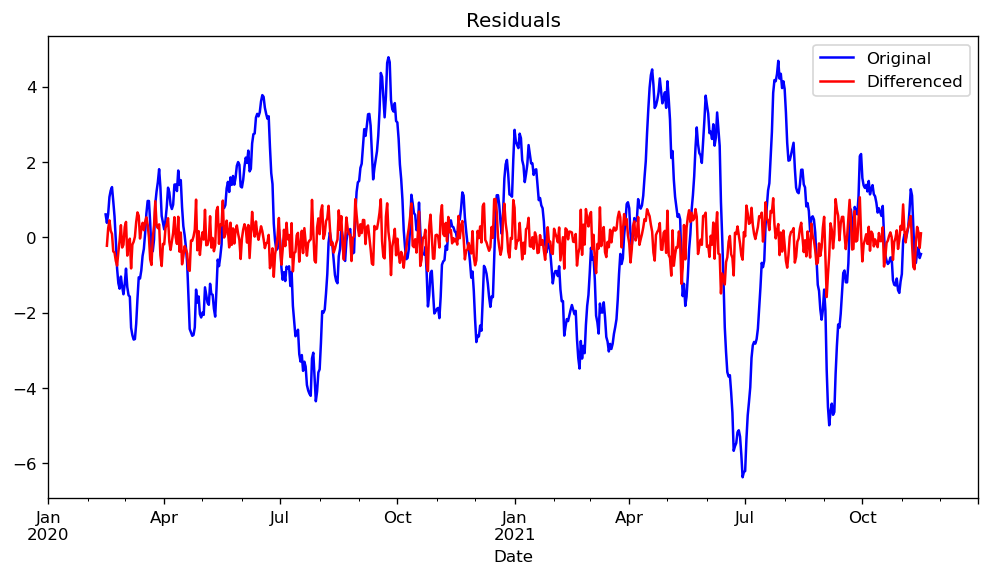

In [143]:
#plot the Residual graph

plt.figure(figsize=(10,5))
plt.title('Residuals')
decomp.resid.plot(color='b', label='Original')
diff_decomp.resid.plot(color='r', label='Differenced')
plt.legend()
plt.show()

In [87]:
# Compute the rolling mean and rolling Standard Deviation
rolmean = df.rolling(window=90).mean() #seasonal level
rolstd = df.rolling(window=90).std()

#print(rolmean, rolstd)

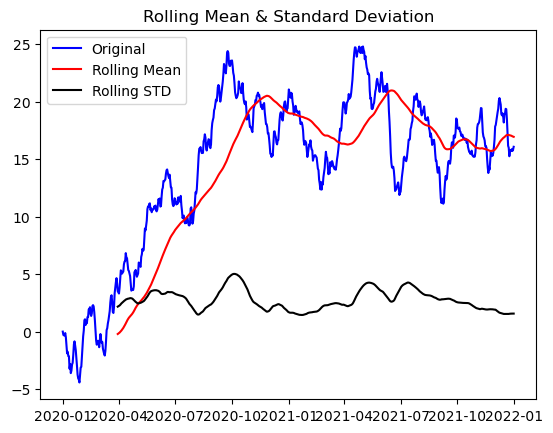

In [17]:
# Visualize the Rolling Mean & Standard Deviation
orig = plt.plot(df, color='b', label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [99]:
# Compute the rolling mean and rolling Standard Deviation
rolmean = df_stationary.rolling(window=90).mean() #seasonal level
rolstd = df_stationary.rolling(window=90).std()

#print(rolmean, rolstd)

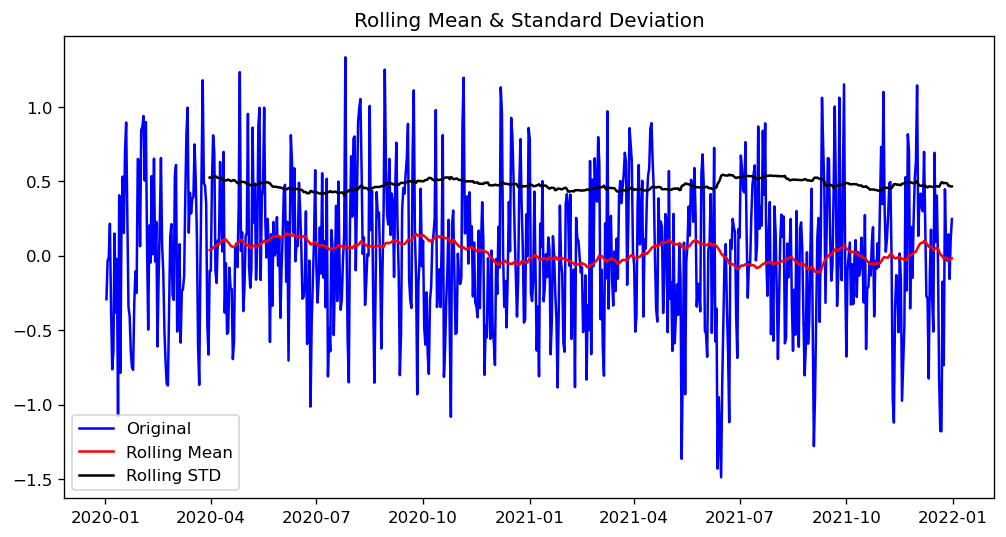

In [34]:
# Visualize the Rolling Mean & Standard Deviation
orig = plt.plot(df_stationary, color='b', label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### D2: ARIMA MODEL <a class="anchor" id="d2"></a>

Since our time series is shown to be non-stationary, this will make it difficult to be able to infer any predictions accurately from the data. Therefore, I used the `.diff` method in Pandas to make the data stationary. This method computes the difference between the current row and the previous row calculating the nth discrete difference along the given axis. This is using the oft quoted proverb that says, “the best predictor of future behavior is past behavior” (Schrader, 2013). I also dropped any null values during this transformation. 

In [94]:
#calculate the difference between consecutive rows in the dataset
df_stationary = df.diff().dropna()
#rename column
df_stationary = df_stationary.rename(columns={'Revenue': 'Return'})
#show the header
df_stationary.head()

,Return
Date,
2020-01-02,-0.292356
2020-01-03,-0.035416
2020-01-04,-0.012215
2020-01-05,0.215100
2020-01-06,-0.366702


The graph of this new data which represents the *returns* instead of *revenue* are shown below. This also shows that the data is now stationary since the data converges on the 0.0 line of the x-axis.

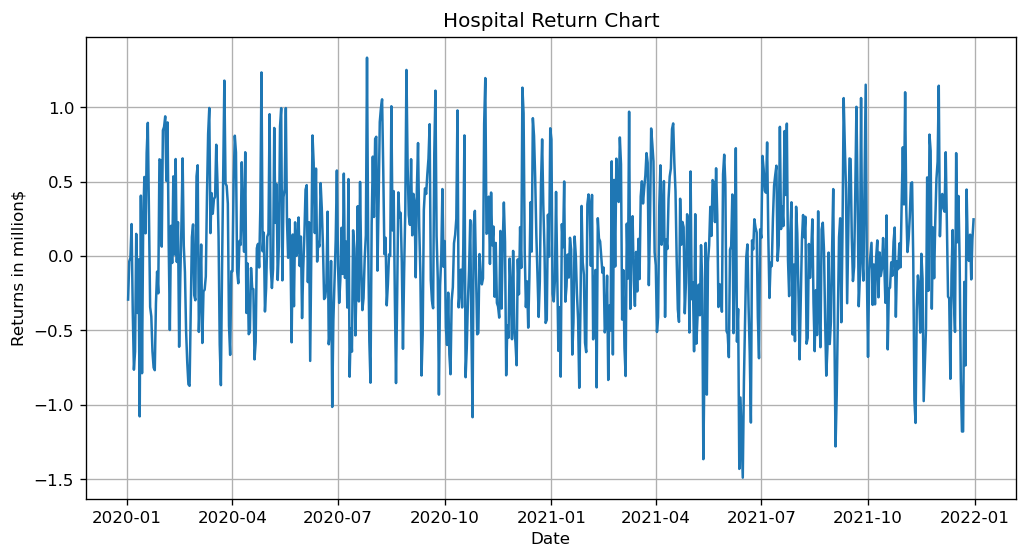

In [32]:
#visualize the first difference time series on a graph
plt.figure(figsize=(10,5))
plt.plot(df_stationary.Return)
plt.title('Hospital Return Chart')
plt.xlabel('Date')
plt.ylabel('Returns in million$')
plt.grid(True)
plt.show()

We can also check the p-value from the Augmented Dickey-Fuller test again to check its significance. 

In [35]:
#check for stationarity using Augmented Dickey-Fuller Test
adf_test(df_stationary['Return'])

The results of the AD Fuller Test - using non-stationary data
1. ADF:  -17.374772303557062
2. P-Value:  5.113206978840171e-30
3. Number of Lags:  0
4. Number of Obs:  729
5. Critical Values: 
	 1% :  -3.4393520240470554
	 5% :  -2.8655128165959236
	 10% :  -2.5688855736949163
6. Best IC:  846.2604386450553


In [36]:
result = adfuller(df_stationary['Return'], autolag='AIC')
alpha = 0.05

if result[1] >= alpha:
    print('The results are not statistically significant. Therefore, we cannot reject the null hypothesis, and must accept it.')
    print("")
else:
    print('The results are statistically significant. Therefore, we reject the null hypothesis.')
    print("")

print("Test Statistic:", round(result[0],5))
print("P-Value:", round(result[1],5))

The results are statistically significant. Therefore, we reject the null hypothesis.

Test Statistic: -17.37477
P-Value: 0.0


This shows that the differenced dataset is now stationary. Therefore, the correct *d* value in our ARIMA model should be 1, since we only differenced the dataset one degree in order to satisfy stationarity. 

By interpreting the `plot_acf` (Autocorrelation Function) graph using this new stationary dataset, we can determine that any lags outside of our confidence intervals represent the *MA* (Moving Average) or *q* value in our ARIMA model. Therefore, the correct MA value looks to be 2. 

Likewise, the `plot_pacf` (Partial Autocorrelation Function) graph will help us to determine the *AR* (Auto Regressive) or *p* value in our ARIMA model, which in this case is 1. 

Both the ACF and PACF graphs are shown in Section D1 above.

We can also use the `auro_arima` function to automatically show us the best order to use for our ARIMA model based on choosing the best AIC metric in each model. 

In [145]:
model = pm.auto_arima(df,
                      d=1,                #d is non-seasonal diff
                      start_p=1, max_p=5, #p is non-seasonal p-value
                      start_q=1, max_q=5, #q is non-seasonal q-value
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.440 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Wed, 30 Oct 2024   AIC                            879.982
Time:                        23:38:31   BIC                            889.168
Sample:                    01-01-2020   HQIC                           883.526
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The above shows us that the best order is actually (1,1,0) and not (1,1,2). Looking at the (1,1,2) ARIMA model, I found that the p-values were not statistically significant, so I am going to proceed with using the order that `auto_arima` gave me. But first, given that our original dataset shows seasonality, I want to also check `auto_arima` using a seasonal metric of 90. 

In [74]:
#use auto-ARIMA to find best model
model = pm.auto_arima(df, 
                      seasonal=True, m=90,
                      d=1, D=1,                    #d is non-seasonal diff, D is seasonal
                      start_p=1, max_p=5, max_P=5, #p is non-seasonal p-value, P is seasonal
                      start_q=1, max_q=5, max_Q=5, #q is non-seasonal q-value, Q is seasonal
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[90]             : AIC=inf, Time=540.09 sec
 ARIMA(0,1,0)(0,1,0)[90]             : AIC=1344.172, Time=7.14 sec
 ARIMA(1,1,0)(1,1,0)[90]             : AIC=inf, Time=36.91 sec
 ARIMA(0,1,1)(0,1,1)[90]             : AIC=inf, Time=162.68 sec
 ARIMA(0,1,0)(1,1,0)[90]             : AIC=inf, Time=24.69 sec
 ARIMA(0,1,0)(0,1,1)[90]             : AIC=inf, Time=203.33 sec
 ARIMA(0,1,0)(1,1,1)[90]             : AIC=inf, Time=117.96 sec
 ARIMA(1,1,0)(0,1,0)[90]             : AIC=1228.526, Time=3.36 sec
 ARIMA(1,1,0)(0,1,1)[90]             : AIC=inf, Time=234.33 sec
 ARIMA(1,1,0)(1,1,1)[90]             : AIC=inf, Time=314.96 sec
 ARIMA(2,1,0)(0,1,0)[90]             : AIC=1230.491, Time=7.88 sec
 ARIMA(1,1,1)(0,1,0)[90]             : AIC=1230.496, Time=10.74 sec
 ARIMA(0,1,1)(0,1,0)[90]             : AIC=1247.950, Time=7.34 sec
 ARIMA(2,1,1)(0,1,0)[90]             : AIC=1231.394, Time=46.09 sec
 ARIMA(1,1,0)(0,1,0)[90] intercept   : AIC=

This seasonality model performs worse than the first `auto_arima` model without seasonality. The ARIMA model with order = (1,1,0) has an AIC of 879.982. The SARIMAX model with order = (1,1,0) and seasonal order = (0,1,0,90) has an AIC of 1228.526. Therefore, the ARIMA model performs better, so I will use this as my model. 

### D3: FORECASTING USING ARIMA MODEL <a class="anchor" id="d3"></a>

In [213]:
# create the ARIMA model
model = ARIMA(X_train, order=(1,1,0))
# fit model and save
results = model.fit()
# create predictions on the training set
prediction = pd.DataFrame(results.predict(n_periods = 12), index=X_train.index)
# rename columns
prediction.columns = ['Revenue']
# show the predictions
prediction

,Revenue
Date,
2020-01-01,0.000000
2020-01-02,0.000000
2020-01-03,-0.412220
2020-01-04,-0.342292
2020-01-05,-0.344995
...,...
2021-09-26,17.480928
2021-09-27,17.027124
2021-09-28,16.799930


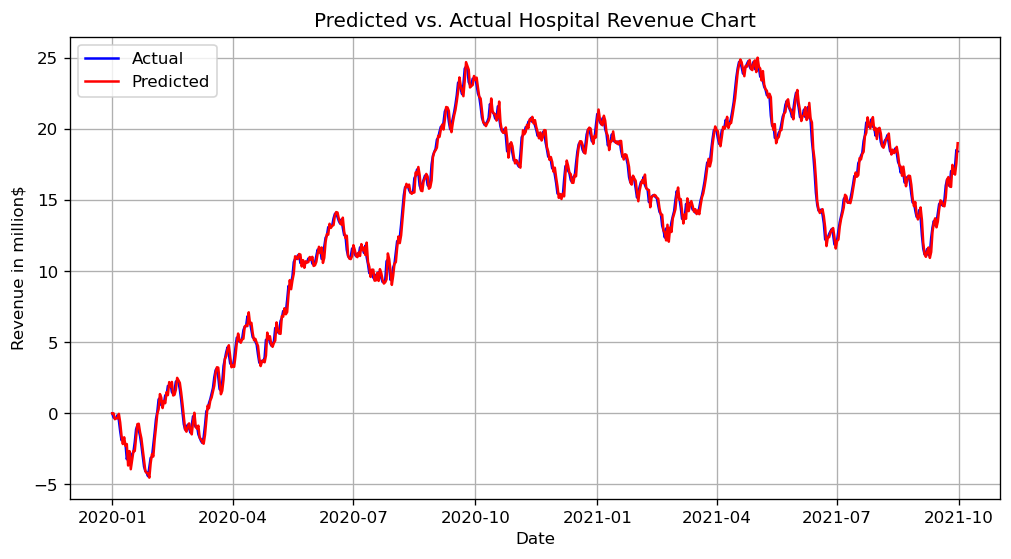

In [214]:
#visualize the original time series with the predicted one
plt.figure(figsize=(10,5))
plt.plot(X_train.Revenue, color='b', label='Actual')
plt.plot(prediction.Revenue, color='r', label='Predicted')
plt.title('Predicted vs. Actual Hospital Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue in million$')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### D4: OUTPUT AND CALCULATIONS <a class="anchor" id="d4"></a>

In [210]:
model = ARIMA(X_train, order=(1,1,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  639
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -387.933
Date:                Thu, 31 Oct 2024   AIC                            779.867
Time:                        22:06:28   BIC                            788.784
Sample:                    01-01-2020   HQIC                           783.328
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4100      0.037     11.194      0.000       0.338       0.482
sigma2         0.1975      0.012     16.543      0.000       0.174       0.221
Ljung-Box (L1) (Q):                   0.00   Jarque-

All other calculations and outputs are extensively covered in the above sections. 

### D5: CODE <a class="anchor" id="d5"></a>

All of the code used in supporting the selection and implementation of the time series model has been outlined and provided in detail in the above steps. 

## PART V: DATA SUMMARY AND IMPLICATIONS <a class="anchor" id="part5"></a>

### E1: RESULTS <a class="anchor" id="e1"></a>

I used several different methods in the selection of the best ARIMA model. First, I observed the original dataset which was proven to be non-stationary. I then differenced this dataset one degree. I found this new dataset (representing the *returns* instead of the *revenue*) was stationary by viewing the decomposed time series plots and evaluating the p-value from the Augmented Dickey-Fuller test. This told me that the correct *d* value was 1. 

Next, I used this stationary data to plot the Autocorrelated Function and Partial Autocorrelation Function to determine the *q* and *p* values, respectively. Visual inspection of these functions gave me a *p* of 1, and a *q* of 2. 

I then performed `auto_arima` to see what Python would say was the best *p,d,q* values. I found this to be order = (1,1,0). This differed from my initial analysis. So I put these values into the ARIMA model and evaluated which models were best given the lowest AIC (Akaike Infomation Criteria) alongwith significant p-values (< 0.05). Given that the original dataset appeared to have a seasonality of 90 days, I also tested several different SARIMAX models, and again used `auto_arima` to determine the best SARIMAX model with a seasonality of 90. 

After looking over many models, I arrived at the best model chosen: ARIMA on the X_train dataset with order = (1,1,0) and no seasonal order. 

The prediction interval of the ARIMA model matches the same length as the test set: 90 days. Given that there appears to be a 90 day seasonality in the original dataset, I felt it was a good size test set to align with this seasonality. This represents 25% of one year of data, or roughly 12.5% of the whole dataset. Typically, when splitting a dataset into training and testing sets, you normally would use 20-30% range for the testing set. But again, given the 90 day seasonality, I felt this would give the hospital the best information for their next quarter. 

#### THE MODEL EVALUATION PROCEDURE AND ERROR METRIC <a class="anchor" id="e1.4"></a>

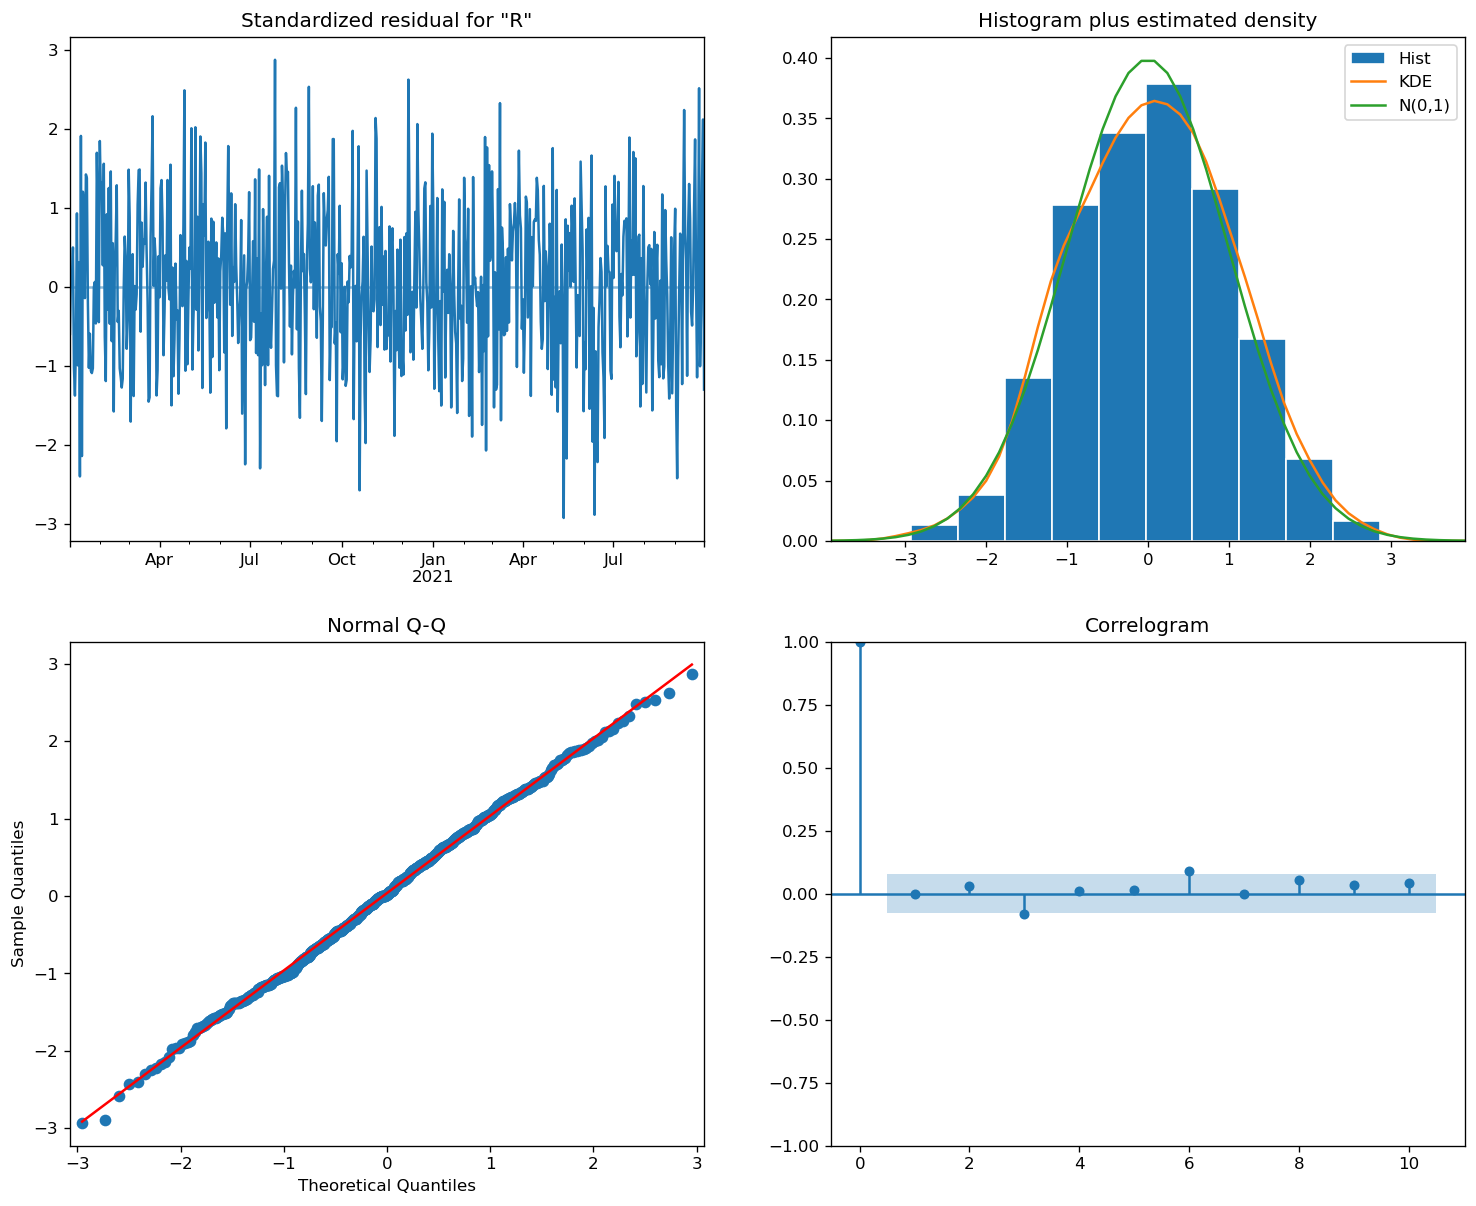

In [211]:
#create 4 diagnostic plots
results.plot_diagnostics(figsize=(15,12))
plt.show()

The `plot_diagnostics` function from `statsmodels` visualizes the model's performance. The *Standardized residual for "R"* (top-left) plot shows that the residuals are randomly scattered, but still centered on zero. There are no obvious patterns in this plot. The *Histogram plus estimated density* plot (top-right) displays the standardized residuals with a KDE (kernel density estimate) which shows our graph is normally distributed. This shows the model is a good fit. The *Normal Q-Q* plot (bottom-left) compares the quantiles of the standardized residuals (blue dots) to the quantiles of a standard normal distribution (red line). Our plot shows that these are very nearly identical, which shows that, again, this model is a good fit. Lastly, the *Correlogram* plot (bottom-right) shows us the Autocorrelation Function which shows very minimal autocorrelation in the residuals. Residual 3 and 6 are slightly outside of the confidence interval, but is neglible. 

In [204]:
# Mean Absolute Error
model = ARIMA(X_train, order=(1,1,0))
results = model.fit()
residuals = results.resid
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error: ', mae)

Mean Absolute Error:  0.359744787746738


The Mean Absolute Error (MAE) is very low, at just 0.356, showing that the difference between the predicted values and actual values are very accurate. I also evaluated the R-Squared metric of the original dataset, training set, and the testing set. As you can see, each of the 3 models shows a very high R-Squared value, with the training set slightly edging out the original dataset for most accurate. 

In [193]:
#compare R-Squared Values
from sklearn.metrics import r2_score

df['predicted_revenue'] = prediction
original_r2 = r2_score(df['Revenue'], df['predicted_revenue'])
print('R-Squared Original Dataset:', round(original_r2 ,5))
X_train['predicted_revenue'] = prediction
train_r2 = r2_score(X_train['Revenue'], X_train['predicted_revenue'])
print('R-Squared Training Set:    ', round(train_r2, 5))
X_test['predicted_revenue'] = prediction
test_r2 = r2_score(X_test['Revenue'], X_test['predicted_revenue'])
print('R-Squared Test Set:        ', round(test_r2, 5))

R-Squared Original Dataset: 0.99599
R-Squared Training Set:     0.99633
R-Squared Test Set:         0.92773


### E2: ANNOTATED VISUALIZATION <a class="anchor" id="e2"></a>

In [203]:
# Create the ARIMA model using best AIC model parameters
model = ARIMA(X_train, order=(1,1,0))
# fit model and save
results = model.fit()
# Forecast/Predict the next 90 days
forecast = results.get_forecast(steps=90)
#adding here
mean_forecast = forecast.predicted_mean
conf_interval = forecast.conf_int()
lower = conf_interval.loc[:,'lower Revenue']
upper = conf_interval.loc[:,'upper Revenue']

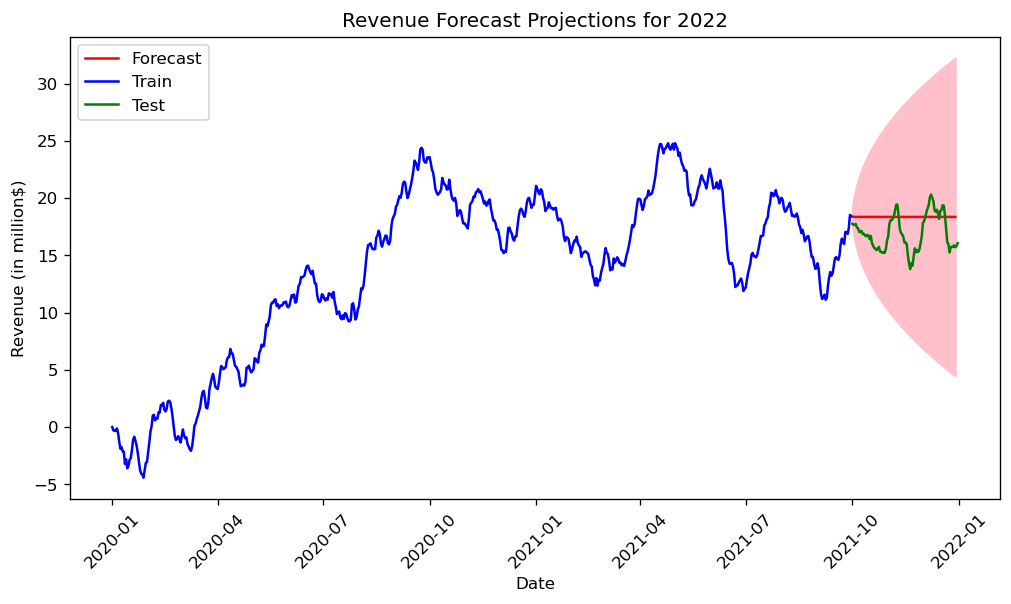

In [215]:
# Plot Forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')
plt.plot(X_train.index, X_train, color='b', label='Train')
plt.plot(X_test.index, X_test, color='g', label='Test')
# Plot confidence intervals
plt.fill_between(lower.index, lower, upper, color='pink')
# Plot Train & Test datasets
#X_train['Revenue'].plot(legend=True, label='Train')
#X_test['Revenue'].plot(legend=True, label='Test')
# Customize the graphs
plt.title('Revenue Forecast Projections for 2022')
plt.xlabel('Date')
plt.ylabel('Revenue (in million$)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
# Show plots
plt.show()

### E3: RECOMMENDATION <a class="anchor" id="e3"></a>

The applied model used to predict revenue is very accurate in this dataset. Comparing the predictions to the original dataset proves to be extremely aligned when viewing on a graph. I would recommend to the hospital leadership that they use this model with their shareholders and board to show what the company's revenue will do over the next quarter. Using the predicted means, we can see pretty steady revenue for the company in the next 90 days around the $19M mark. The prediction is relatively flat, so they can ascertain that there shouldn't be a big decline nor a large influx in revenue. They should use this information to strategically align their hospital's goals and objectives while being fiscally responsible. Given this prediction, I would recommend that the hospital leadership not making any large changes or make any large expenditures over the next 90 days. Rather, I would recommend they *stay the course*. After 90 days is over, then I would evaluate this model against the actual data to see how well it was at forecasting real data. Then I would continue to evaluate the next 90 days, and would continue to do this every quarter making wise decisions given the predictions at each turn. 

## PART VI: REPORTING <a class="anchor" id="part6"></a>

### F: REPORTING <a class="anchor" id="f"></a>

The Jupyter Notebook has been provided in Adobe PDF format for this presentation. 

### G: SOURCES FOR THIRD-PARTY CODE <a class="anchor" id="g"></a>

Pandas (2023, June 28). Retrieved September 27, 2023, from https://pandas.pydata.org/docs/reference/index.html.

Waskom, M. (2012-2022). Seaborn Statistical Data Visualization. Retrieved September 27, 2023, from https://seaborn.pydata.org/index.html.

Seabold, S., Perktold, J. (2010). statsmodels: Econometric and statistical modeling with python. Proceedings of the 9th Python in Science Conference. Retrieved November 1, 2024, from https://www.statsmodels.org/stable/index.html.

Smith, T. (2017-2023). pmdarima: ARIMA estimators for Python. Retrieved November 1, 2024, from https://alkaline-ml.com/pmdarima/.

Pérez, F., Granger, B. IPython: A System for Interactive Scientific Computing, Computing in Science and Engineering, vol. 9, no. 3, pp. 21-29, May/June 2007, doi:10.1109/MCSE.2007.53. URL: https://ipython.org

hardikkushwaha. (2023, October 18). How to Add a Table of Contents in the Jupyter Notebook. Retrieved November 1, 2024, from https://www.geeksforgeeks.org/how-to-add-a-table-of-contents-in-the-jupyter-notebook/.


### H: SOURCES <a class="anchor" id="h"></a>

Bruce, P.A. (2020). Practical statistics for data scientists. 50+ essential concepts using r and python. O’Reilly Media, Incorporated. WGU Library.

Larose, C.D., Larose, D.T. (2019) Data science using Python and R. Chichester, NJ: Wiley Blackwell.

Schrader, J. (January 3, 2013). The Best Predictor of Future Behavior Is… Past Behavior. Retrieved on October 27, 2024, from https://www.psychologytoday.com/intl/blog/witness/201301/the-best-predictor-future-behavior-is-past-behavior.

Statistic Solutions. (2024). The Stationarity Data Assumption in Time Series Analysis. Retrieved on November 1, 2024, from https://www.statisticssolutions.com/stationary-data-assumption-in-time-series-analysis.

Rodrigo, J., Ortiz, J. (2024, August). ARIMA and SARIMAX models with Python. Retrieved on November 1, 2024, from https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html.

Nishtha. (2024, October 19). How to check Stationarity of Data in Python. Retrieved November 1, 2024, from https://www.analyticsvidhya.com/blog/2021/04/how-to-check-stationarity-of-data-in-python.

Tate, A. (2023, December 18). Detecting Seasonality Through Autocorrelation. Retrieved on November 1, 2024, from https://hex.tech/blog/detecting-seasonality-through-autocorrelation.

Jones, J. (2018, February 19). Time Series and Spectral Analysis. Retrieved on November 1, 2024, from https://web.stanford.edu/class/earthsys214/notes/series.html.